<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/05.trees-and-ensembles/05.trees-and-ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from collections import Counter

from imblearn.over_sampling import SMOTE
import sys
sys.path.append("..")
from Module.visualization import plot_conf_mat, plot_feature_importances

%load_ext autotime

import pickle # To save the model
from os.path import isfile

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.07 ms (started: 2025-05-27 01:17:00 +02:00)


# Load dataset and preliminary operations


In [45]:
mydatasets_folder = "../Data/"
train_path = mydatasets_folder+"diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
df = pd.read_csv(train_path)
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


time: 250 ms (started: 2025-05-27 01:17:00 +02:00)


In [46]:
df = df.drop(labels=['Sex', 'Smoker', 'Stroke','Fruits','AnyHealthcare','NoDocbcCost'], axis=1)
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,HeartDiseaseorAttack,PhysActivity,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,1.0,1.0,0.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


time: 31 ms (started: 2025-05-27 01:17:00 +02:00)


Let's partition the dataset in training and test dataset

In [47]:
X = df.drop(labels='Diabetes_binary', axis=1)
y = df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                        shuffle=True, random_state=4)

time: 29.1 ms (started: 2025-05-27 01:17:00 +02:00)


Check for class imbalance and correct for it

In [48]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Samples per class before SMOTE:", Counter(y_train))

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Samples per class after SMOTE:", Counter(y_train))


Samples per class before SMOTE: Counter({1.0: 24777, 0.0: 24707})
Samples per class after SMOTE: Counter({0.0: 24777, 1.0: 24777})
time: 2.08 s (started: 2025-05-27 01:17:00 +02:00)


# Training and testing a random forest

In [49]:
model = RandomForestClassifier(n_estimators=100,
                      criterion='gini',
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt' # auto means=sqrt(n_features)
                      )

model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=5)

time: 517 ms (started: 2025-05-27 01:17:02 +02:00)


Normalized confusion matrix
[[0.69066642 0.30933358]
 [0.21525215 0.78474785]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

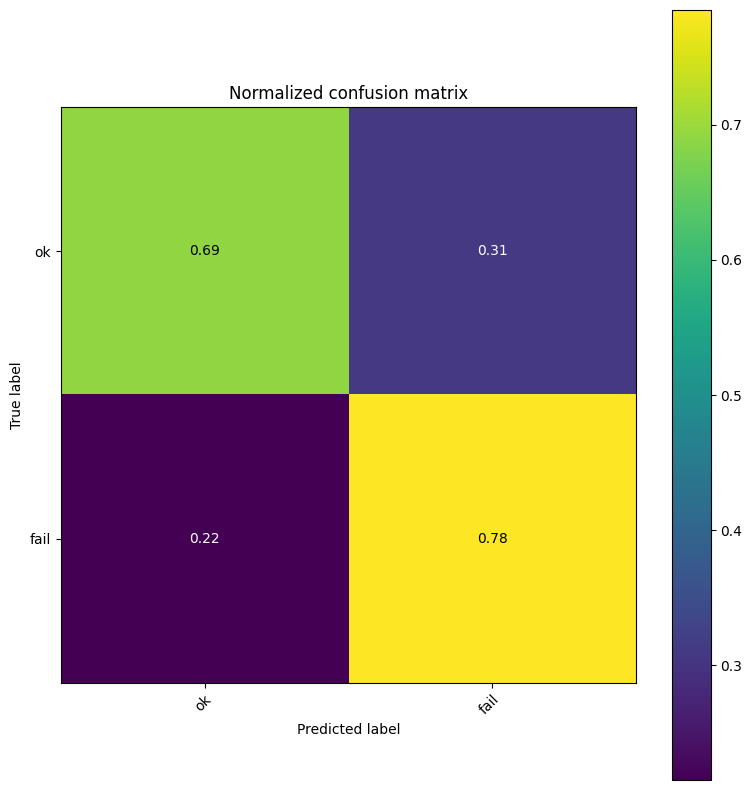

time: 326 ms (started: 2025-05-27 01:17:03 +02:00)


In [50]:
y_pred = model.predict(X_test)
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)

Let's check the feature importance

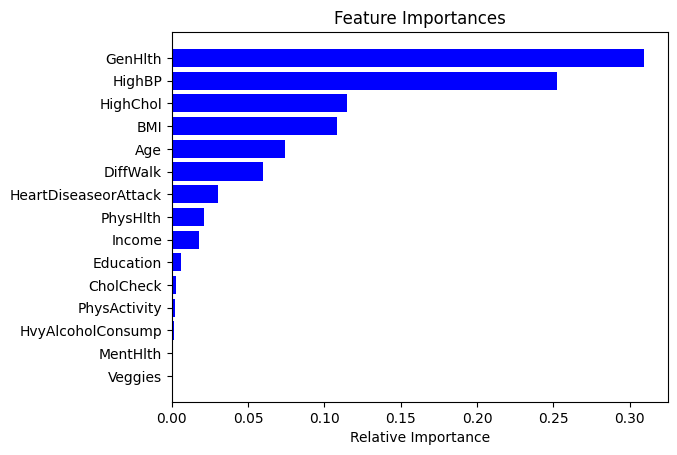

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack',
       'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
       'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income'],
      dtype='object')

time: 250 ms (started: 2025-05-27 01:17:03 +02:00)


In [51]:
feature_names = X_test.columns
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

Memory and Disk are the most determining factors in producing a failure

# Hyperparameter tuning
You have three possibility:
* Manual tuning:
  * Divide the training set in training subset and validation subset
  * Train different classifiers (with different hyperparameters) on the training subset
  * Check their performance, i.e., accuracy, on the validation subset
  * Choose the best
  * Test it on the test set
* `GridSearchCV` (as in `02.regression/b.polynomial-regression.ipynb`)
* `RandomizedSearchCV`

We use the latter now. See [Open Data Science post](https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead).

Let's first define the values of the parameters we want to explore

In [52]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':[1,2,3,4,5],

    # Number of allowed leafs
    'max_leaf_nodes':[16, 32, 64, 128, 256, 512, 1024, 2048],

    # A node will be split if this split induces a decrease of the
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1, 0.2],

    'max_depth':[1,10,100,1000,10000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0.001, 0]

}

time: 1.39 ms (started: 2025-05-27 01:17:04 +02:00)


We have a lot of possible configurations to check. We specify to just test 50
out of them.


In [53]:
# Before we had used all the availble CPUs for training one random forest.
# Now, instead, we use one CPU per random forest (n_jobs=1).
forest = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

                            estimator=forest,
                            param_distributions=param_grid,
                            n_iter=50, # We just test 50 configurations
                            verbose=2,random_state=42,
                            n_jobs=-1, # Triain forests in parallel using
                                      # all CPUs
                            cv=5 # 5-fold validation
                          )
# Note that we are training different random forests in parallel (n_jobs=-1),
# each with a certain combination of hyper-parameters.

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=1, random_state=4),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 10, 100, 1000, 10000,
                                                      100000],
                                        'max_features': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [16, 32, 64, 128, 256,
                                                           512, 1024, 2048],
                                        'min_impurity_decrease': [0, 0.001,
                                                                  0.01, 0.1,
                                                                  0.2],
                                        'min_weight_fraction_leaf': [0.1, 0.01,
                                                                     0.001,
                                                                     0]},
                   random_state=42, scoring='accuracy', verbose=2)

time: 1min 9s (started: 2025-05-27 01:17:04 +02:00)


In [54]:
print(search.best_params_)

model = search.best_estimator_


{'min_weight_fraction_leaf': 0.001, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 32, 'max_features': 5, 'max_depth': 10000, 'criterion': 'entropy'}
time: 1.32 ms (started: 2025-05-27 01:18:13 +02:00)


Now that we have the model with the best hyperparameters, we train it on the entire dataset

Normalized confusion matrix
[[0.68211298 0.31788702]
 [0.20039739 0.79960261]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

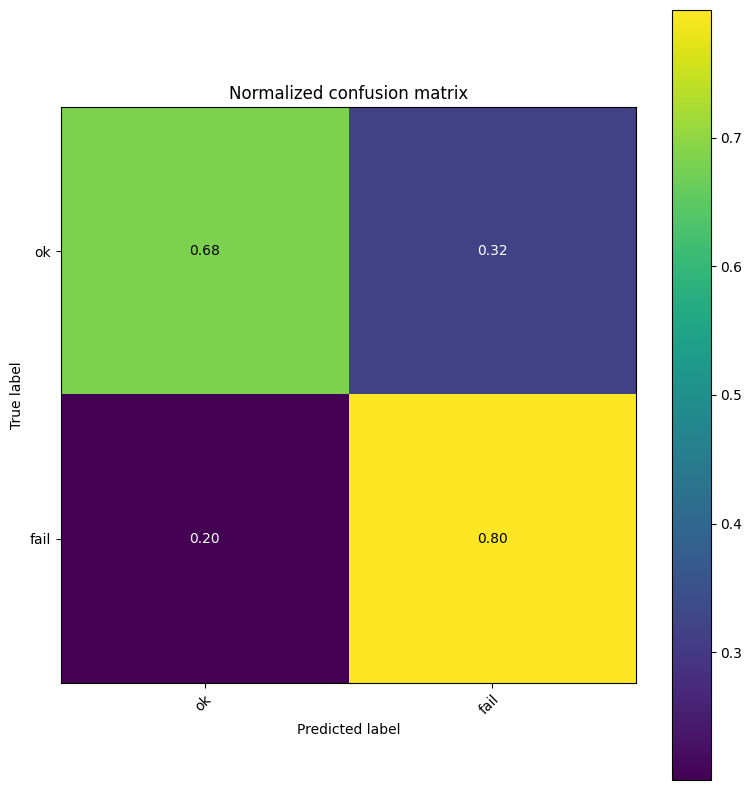

time: 2.3 s (started: 2025-05-27 01:18:13 +02:00)


In [55]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plot_conf_mat(y_test, y_pred, class_names)

Note that we get also get probabilities with RandomForests (fraction of trees that predicted `1`). And thus, we can compute cross-entropy

In [56]:
proba = model.predict_proba(X_test)
print("Output probabilities are ",proba)


print("Cross entropy = ", log_loss(y_test, proba))

Output probabilities are  [[0.84180161 0.15819839]
 [0.29813844 0.70186156]
 [0.52662328 0.47337672]
 ...
 [0.26964161 0.73035839]
 [0.58924615 0.41075385]
 [0.1920076  0.8079924 ]]
Cross entropy =  0.5253099608854473
time: 127 ms (started: 2025-05-27 01:18:15 +02:00)


Don't confuse cross-entropy with entropy of a tree node!

Since it may take some time to perform randomized search, let's save the model (**serializing** the python object)

In [57]:
# filename = train_path
# pickle.dump(model, open(filename, 'wb'))

time: 850 μs (started: 2025-05-27 01:18:15 +02:00)


To later retrieve it:



In [58]:
# model = pickle.load(open(filename, 'rb'))

time: 5.3 ms (started: 2025-05-27 01:18:15 +02:00)


It is convenient to automate this process

In [59]:
def search_or_load(model_filename, search, X_train, y_train):
  if(isfile(model_filename) ):
    print("Loading model")
    model = pickle.load(open(model_filename, 'rb'))

  else:
    print("Searching the best hyper_parameters")
    search.fit(X_train, y_train)
    print(search.best_params_)
    model = search.best_estimator_
    print("Training model")
    model.fit(X_train,y_train)
    pickle.dump(model, open(model_filename, 'wb'))
    print("Model saved in in file ", model_filename)
  return model


time: 1.25 ms (started: 2025-05-27 01:18:15 +02:00)


If we call this function, it will not redo the search, as the model has already been saved

In [60]:
# model = search_or_load(filename, search, X_train, y_train)

time: 765 μs (started: 2025-05-27 01:18:15 +02:00)


### More iterations


Let's try to increase the number of tested configurations
